## Importation des bibliothèques

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


## Chargement des données, de notre dataset

In [9]:
file_path = "D:\\MEMO\\dataset\\statlog+shuttle\\shuttle.tst"
data = pd.read_csv(file_path, delim_whitespace=True, header=None, engine='python')

C:\Users\elton\AppData\Local\Temp\ipykernel_34676\17660.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, engine='python')


## Exploration des données

In [11]:
data

,0,1,2,3,4,5,6,7,8,9
0,55,0,81,0,-6,11,25,88,64,4
1,56,0,96,0,52,-4,40,44,4,4
2,50,-1,89,-7,50,0,39,40,2,1
3,53,9,79,0,42,-2,25,37,12,4
4,55,2,82,0,54,-6,26,28,2,1
...,...,...,...,...,...,...,...,...,...,...
14495,80,0,84,0,-36,-29,4,120,116,5
14496,55,0,81,0,-20,25,26,102,76,4
14497,55,0,77,0,12,-22,22,65,42,4
14498,37,0,103,0,18,-16,66,85,20,1


In [12]:
data.shape

(14500, 10)

In [13]:
data.dtypes

0    int64
1    int64
2    int64
3    int64
4    int64
5    int64
6    int64
7    int64
8    int64
9    int64
dtype: object

In [14]:
print(data.columns)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


## Binarisation de la cible 


In [16]:
# Séparation des caractéristiques et de la cible
X = data.iloc[:, :-1]  # Colonnes 0 à 8
y = data.iloc[:, -1]   # Colonne 9

In [17]:
# Binarisation de la cible : classe 1 (normale) = 0, autres classes (anomalies) = 1
y_binary = (y != 1).astype(int)


In [18]:
# Standardisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

In [20]:
# Modèle Isolation Forest
isolation_forest = IsolationForest(random_state=42, contamination=y_train.mean())
isolation_forest.fit(X_train)

IsolationForest(contamination=0.20844827586206896, random_state=42)

In [21]:
# Prédictions : -1 pour anomalies, 1 pour normales (convertir en binaire)
y_pred_train = (isolation_forest.predict(X_train) == -1).astype(int)
y_pred_test = (isolation_forest.predict(X_test) == -1).astype(int)

Rapport de classification pour Isolation Forest:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2296
           1       0.53      0.52      0.53       604

    accuracy                           0.80      2900
   macro avg       0.70      0.70      0.70      2900
weighted avg       0.80      0.80      0.80      2900



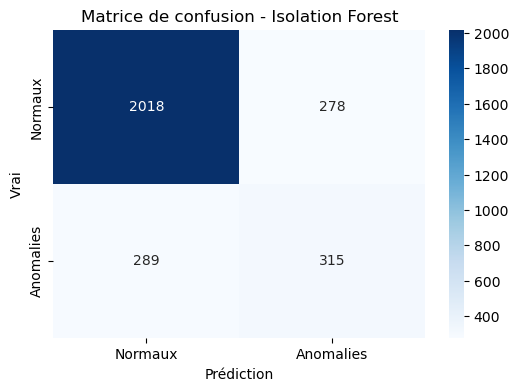

Metrics: {'Precision': 0.5311973018549747, 'Recall': 0.5215231788079471, 'F1-Score': 0.5263157894736842, 'Accuracy': 0.8044827586206896}


In [22]:
# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, model_name):
    print(f"Rapport de classification pour {model_name}:\n")
    print(classification_report(y_true, y_pred))

 # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Normaux", "Anomalies"],
        yticklabels=["Normaux", "Anomalies"]
    )
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vrai")
    plt.show()
    
    # Précision, rappel, F1-score
    metrics = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Precision": metrics["1"]["precision"],
        "Recall": metrics["1"]["recall"],
        "F1-Score": metrics["1"]["f1-score"],
        "Accuracy": metrics["accuracy"]
    }

# Évaluation sur les données de test
metrics = evaluate_model(y_test, y_pred_test, "Isolation Forest")
print("Metrics:", metrics)

In [24]:
# PCA robuste
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [26]:
# Reconstruire les données après PCA
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_test_reconstructed = pca.inverse_transform(X_test_pca)

In [28]:
# Calcul des erreurs de reconstruction (distance euclidienne)
train_reconstruction_error = np.linalg.norm(X_train - X_train_reconstructed, axis=1)
test_reconstruction_error = np.linalg.norm(X_test - X_test_reconstructed, axis=1)

In [31]:
# Définir un seuil basé sur les erreurs de reconstruction
threshold = np.percentile(train_reconstruction_error, 95)


In [37]:
# Prédictions
y_pred_train_pca = (train_reconstruction_error > threshold).astype(int)
y_pred_test_pca = (test_reconstruction_error > threshold).astype(int)


Rapport de classification pour PCA Robuste:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2296
           1       0.36      0.09      0.14       604

    accuracy                           0.78      2900
   macro avg       0.58      0.52      0.51      2900
weighted avg       0.71      0.78      0.72      2900



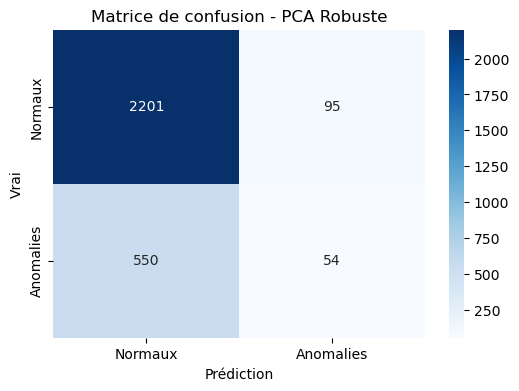

Metrics PCA: {'Precision': 0.3624161073825503, 'Recall': 0.08940397350993377, 'F1-Score': 0.14342629482071714, 'Accuracy': 0.7775862068965518}


In [46]:
# Évaluation du modèle PCA
metrics_pca = evaluate_model(y_test, y_pred_test_pca, "PCA Robuste")
print("Metrics PCA:", metrics_pca)

In [50]:
# Modèle LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=y_train.mean(), novelty=True)
lof.fit(X_train)


LocalOutlierFactor(contamination=0.20844827586206896, novelty=True)

In [51]:
# Prédictions : -1 pour anomalies, 1 pour normales (convertir en binaire)
y_pred_train_lof = (lof.predict(X_train) == -1).astype(int)
y_pred_test_lof = (lof.predict(X_test) == -1).astype(int)


Rapport de classification pour Local Outlier Factor:

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      2296
           1       0.23      0.25      0.24       604

    accuracy                           0.68      2900
   macro avg       0.52      0.52      0.52      2900
weighted avg       0.68      0.68      0.68      2900



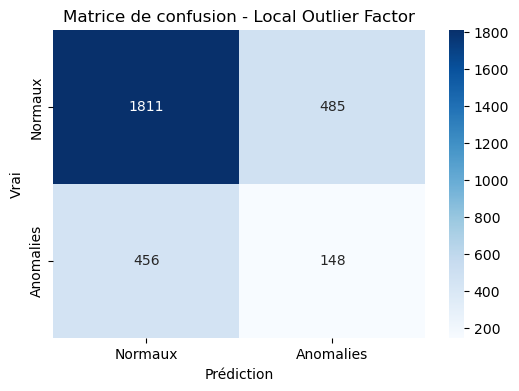

Metrics LOF: {'Precision': 0.23380726698262244, 'Recall': 0.24503311258278146, 'F1-Score': 0.2392886014551334, 'Accuracy': 0.6755172413793104}


In [52]:
# Évaluation du modèle LOF
metrics_lof = evaluate_model(y_test, y_pred_test_lof, "Local Outlier Factor")
print("Metrics LOF:", metrics_lof)

Rapport de classification pour Isolation Forest - Contamination 1.00%:

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2296
           1       1.00      0.05      0.10       604

    accuracy                           0.80      2900
   macro avg       0.90      0.53      0.49      2900
weighted avg       0.84      0.80      0.72      2900



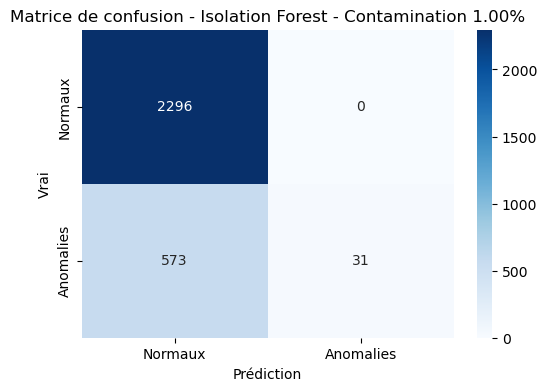

Rapport de classification pour Isolation Forest - Contamination 5.83%:

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2296
           1       0.98      0.26      0.41       604

    accuracy                           0.84      2900
   macro avg       0.91      0.63      0.66      2900
weighted avg       0.87      0.84      0.81      2900



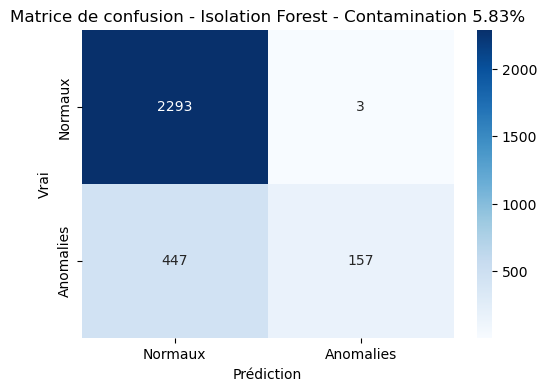

Rapport de classification pour Isolation Forest - Contamination 10.67%:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2296
           1       0.76      0.37      0.50       604

    accuracy                           0.84      2900
   macro avg       0.81      0.67      0.70      2900
weighted avg       0.83      0.84      0.82      2900



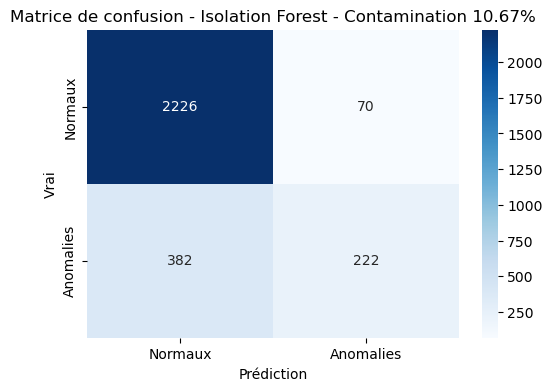

Rapport de classification pour Isolation Forest - Contamination 15.50%:

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2296
           1       0.61      0.43      0.51       604

    accuracy                           0.82      2900
   macro avg       0.74      0.68      0.70      2900
weighted avg       0.81      0.82      0.81      2900



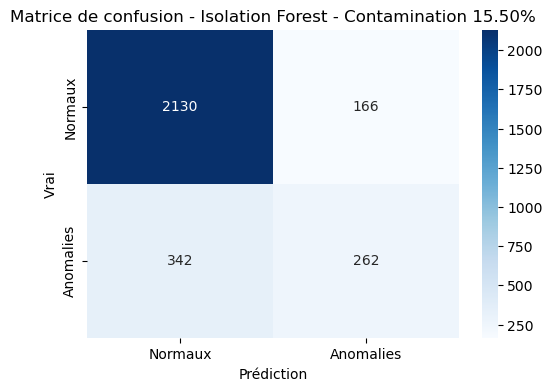

Rapport de classification pour Isolation Forest - Contamination 20.33%:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2296
           1       0.54      0.51      0.52       604

    accuracy                           0.81      2900
   macro avg       0.70      0.70      0.70      2900
weighted avg       0.80      0.81      0.80      2900



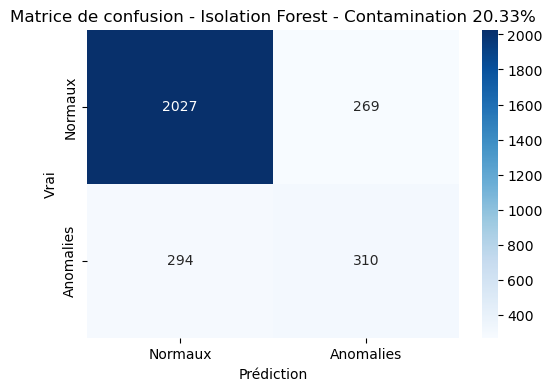

Rapport de classification pour Isolation Forest - Contamination 25.17%:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2296
           1       0.49      0.57      0.53       604

    accuracy                           0.79      2900
   macro avg       0.69      0.71      0.70      2900
weighted avg       0.80      0.79      0.79      2900



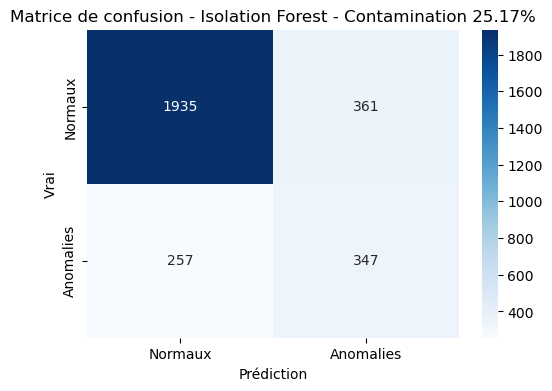

Rapport de classification pour Isolation Forest - Contamination 30.00%:

              precision    recall  f1-score   support

           0       0.90      0.80      0.84      2296
           1       0.46      0.64      0.54       604

    accuracy                           0.77      2900
   macro avg       0.68      0.72      0.69      2900
weighted avg       0.80      0.77      0.78      2900



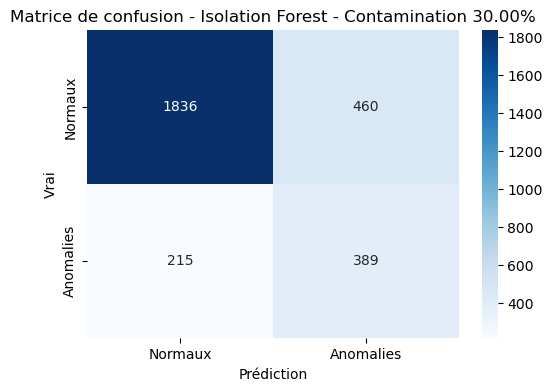

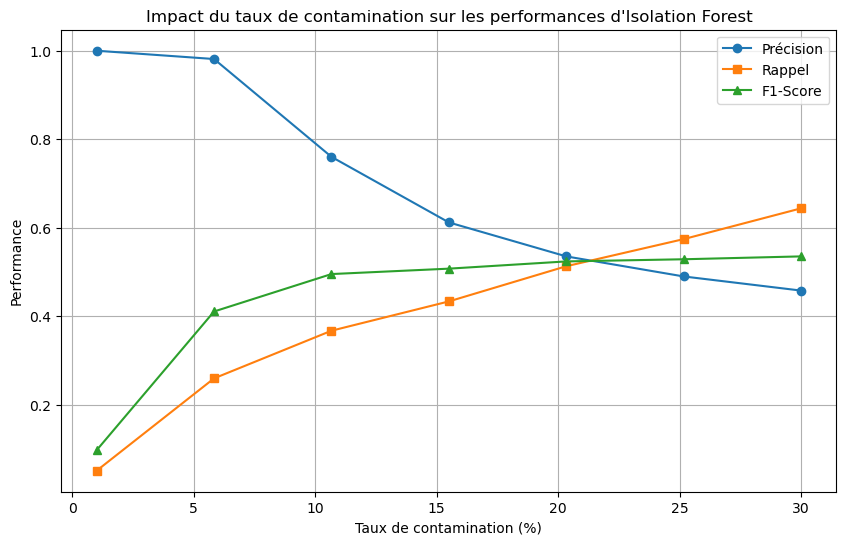

In [58]:
# Liste des taux de contamination à tester (de 1% à 30%)
contamination_rates = np.linspace(0.01, 0.3, 7)  # Évite 0.0

# Stockage des métriques pour chaque taux de contamination
results = {
    "Contamination": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Boucle sur les taux de contamination
for contamination_rate in contamination_rates:
    # Modèle Isolation Forest avec le taux de contamination actuel
    isolation_forest = IsolationForest(random_state=42, contamination=contamination_rate)
    isolation_forest.fit(X_train)
    # Prédictions sur l'ensemble de test
    y_pred_test = (isolation_forest.predict(X_test) == -1).astype(int)
    # Évaluation des performances
    metrics = evaluate_model(y_test, y_pred_test, f"Isolation Forest - Contamination {contamination_rate:.2%}")
    # Stocker les résultats
    results["Contamination"].append(contamination_rate * 100)  # Convertir en pourcentage
    results["Precision"].append(metrics["Precision"])
    results["Recall"].append(metrics["Recall"])
    results["F1-Score"].append(metrics["F1-Score"])

# Conversion des résultats en DataFrame pour faciliter l'analyse
results_df = pd.DataFrame(results)

# Tracé des courbes pour chaque métrique
plt.figure(figsize=(10, 6))
plt.plot(results_df["Contamination"], results_df["Precision"], label="Précision", marker='o')
plt.plot(results_df["Contamination"], results_df["Recall"], label="Rappel", marker='s')
plt.plot(results_df["Contamination"], results_df["F1-Score"], label="F1-Score", marker='^')
plt.title("Impact du taux de contamination sur les performances d'Isolation Forest")
plt.xlabel("Taux de contamination (%)")
plt.ylabel("Performance")
plt.legend()
plt.grid()
plt.show()


Rapport de classification pour PCA Robuste - Contamination 1.00%:

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2296
           1       0.94      0.05      0.10       604

    accuracy                           0.80      2900
   macro avg       0.87      0.53      0.49      2900
weighted avg       0.83      0.80      0.72      2900



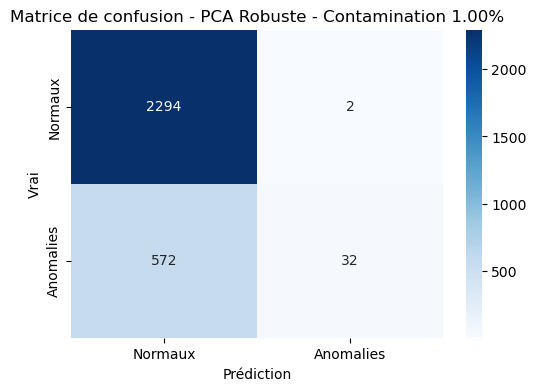

Rapport de classification pour PCA Robuste - Contamination 5.83%:

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      2296
           1       0.91      0.24      0.38       604

    accuracy                           0.84      2900
   macro avg       0.87      0.62      0.64      2900
weighted avg       0.85      0.84      0.80      2900



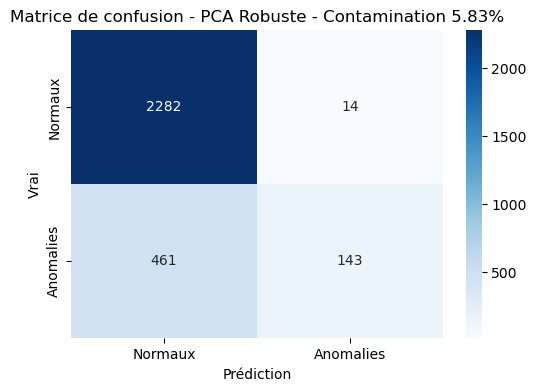

Rapport de classification pour PCA Robuste - Contamination 10.67%:

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2296
           1       0.64      0.31      0.42       604

    accuracy                           0.82      2900
   macro avg       0.74      0.63      0.66      2900
weighted avg       0.80      0.82      0.79      2900



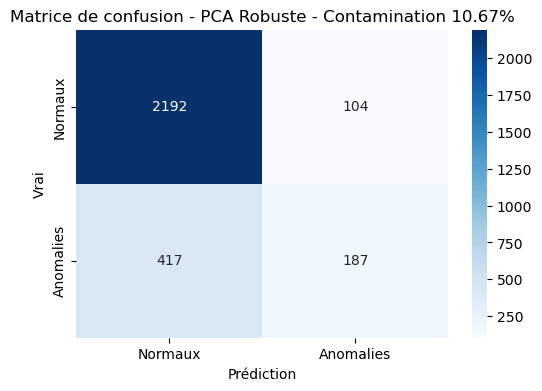

Rapport de classification pour PCA Robuste - Contamination 15.50%:

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      2296
           1       0.51      0.35      0.42       604

    accuracy                           0.79      2900
   macro avg       0.68      0.63      0.65      2900
weighted avg       0.77      0.79      0.78      2900



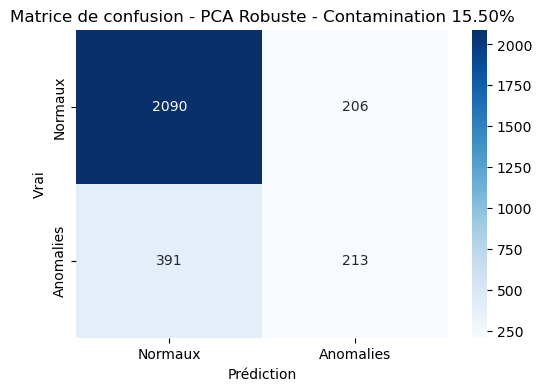

Rapport de classification pour PCA Robuste - Contamination 20.33%:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2296
           1       0.43      0.40      0.41       604

    accuracy                           0.76      2900
   macro avg       0.64      0.63      0.63      2900
weighted avg       0.76      0.76      0.76      2900



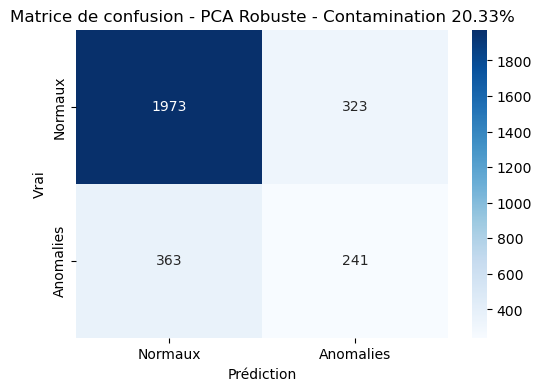

Rapport de classification pour PCA Robuste - Contamination 25.17%:

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      2296
           1       0.37      0.44      0.40       604

    accuracy                           0.73      2900
   macro avg       0.61      0.62      0.61      2900
weighted avg       0.75      0.73      0.74      2900



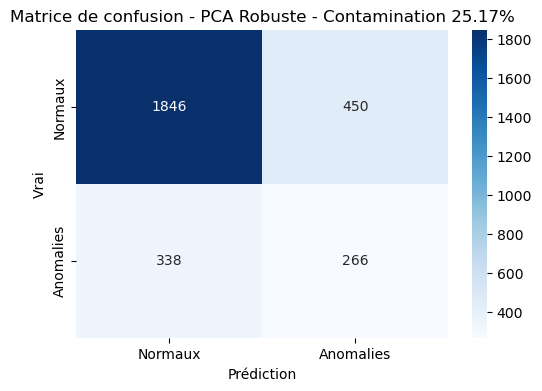

Rapport de classification pour PCA Robuste - Contamination 30.00%:

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      2296
           1       0.34      0.49      0.40       604

    accuracy                           0.70      2900
   macro avg       0.60      0.62      0.60      2900
weighted avg       0.74      0.70      0.72      2900



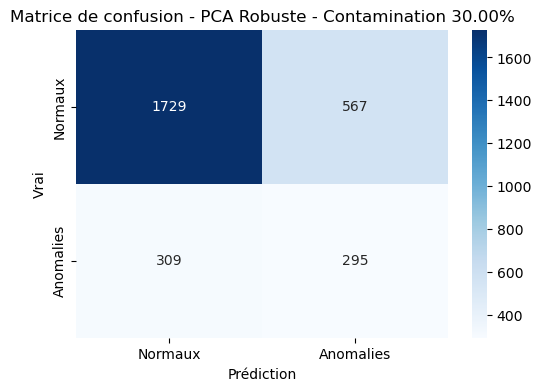

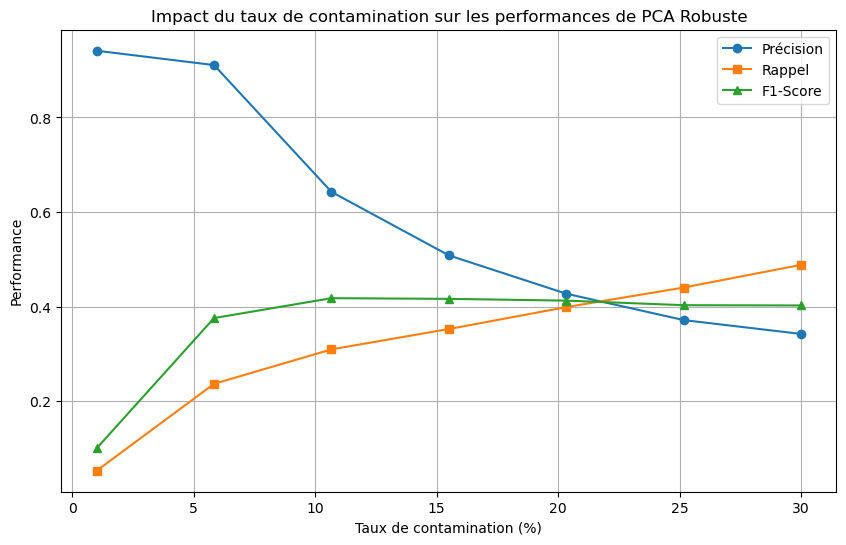

In [60]:
from sklearn.covariance import EllipticEnvelope

# Liste des taux de contamination à tester (de 1% à 30%)
contamination_rates = np.linspace(0.01, 0.3, 7)

# Stockage des métriques pour chaque taux de contamination
results = {
    "Contamination": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Boucle sur les taux de contamination
for contamination_rate in contamination_rates:
    # Modèle PCA Robuste avec le taux de contamination actuel
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Calcul des erreurs de reconstruction
    X_train_reconstructed = pca.inverse_transform(X_train_pca)
    reconstruction_error_train = np.linalg.norm(X_train - X_train_reconstructed, axis=1)
    
    X_test_reconstructed = pca.inverse_transform(X_test_pca)
    reconstruction_error_test = np.linalg.norm(X_test - X_test_reconstructed, axis=1)
    
    # Définir le seuil d'anomalie basé sur le taux de contamination
    seuil = np.percentile(reconstruction_error_train, (1 - contamination_rate) * 100)
    
    # Classification des anomalies
    y_pred_test = (reconstruction_error_test > seuil).astype(int)
    
    # Évaluation des performances
    metrics = evaluate_model(y_test, y_pred_test, f"PCA Robuste - Contamination {contamination_rate:.2%}")
    
    # Stocker les résultats
    results["Contamination"].append(contamination_rate * 100)  # Convertir en pourcentage
    results["Precision"].append(metrics["Precision"])
    results["Recall"].append(metrics["Recall"])
    results["F1-Score"].append(metrics["F1-Score"])

# Conversion des résultats en DataFrame pour faciliter l'analyse
results_df = pd.DataFrame(results)

# Tracé des courbes pour chaque métrique
plt.figure(figsize=(10, 6))
plt.plot(results_df["Contamination"], results_df["Precision"], label="Précision", marker='o')
plt.plot(results_df["Contamination"], results_df["Recall"], label="Rappel", marker='s')
plt.plot(results_df["Contamination"], results_df["F1-Score"], label="F1-Score", marker='^')
plt.title("Impact du taux de contamination sur les performances de PCA Robuste")
plt.xlabel("Taux de contamination (%)")
plt.ylabel("Performance")
plt.legend()
plt.grid()
plt.show()


Rapport de classification pour Local Outlier Factor - Contamination 1.00%:

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2296
           1       0.71      0.04      0.08       604

    accuracy                           0.80      2900
   macro avg       0.76      0.52      0.48      2900
weighted avg       0.78      0.80      0.72      2900



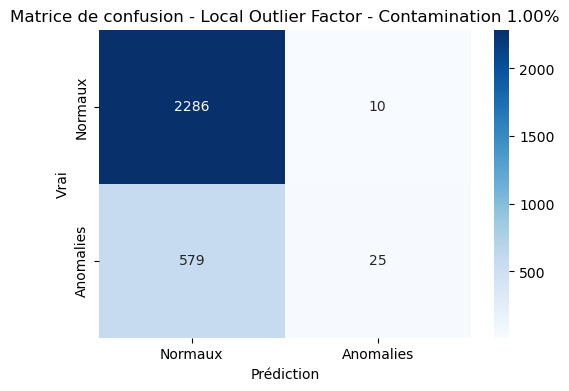

Rapport de classification pour Local Outlier Factor - Contamination 5.83%:

              precision    recall  f1-score   support

           0       0.80      0.96      0.88      2296
           1       0.42      0.11      0.18       604

    accuracy                           0.78      2900
   macro avg       0.61      0.54      0.53      2900
weighted avg       0.72      0.78      0.73      2900



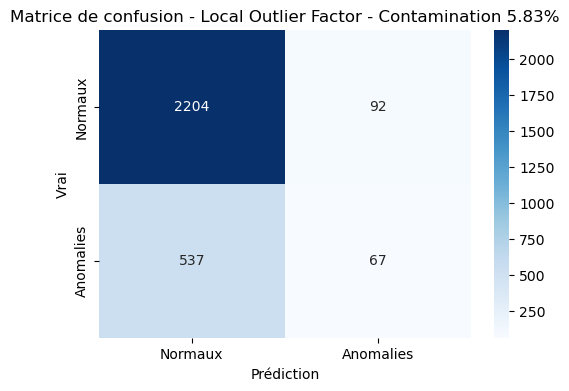

Rapport de classification pour Local Outlier Factor - Contamination 10.67%:

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2296
           1       0.31      0.16      0.21       604

    accuracy                           0.75      2900
   macro avg       0.56      0.53      0.53      2900
weighted avg       0.70      0.75      0.72      2900



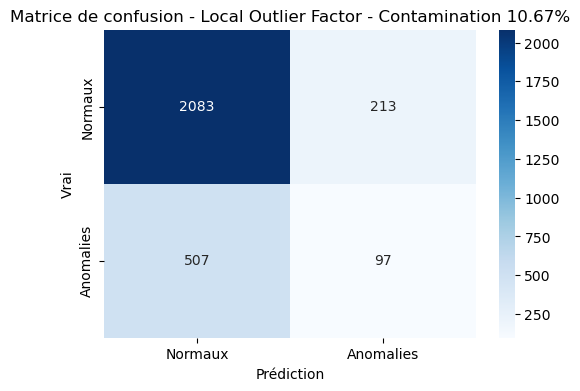

Rapport de classification pour Local Outlier Factor - Contamination 15.50%:

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2296
           1       0.26      0.20      0.22       604

    accuracy                           0.71      2900
   macro avg       0.53      0.52      0.52      2900
weighted avg       0.69      0.71      0.70      2900



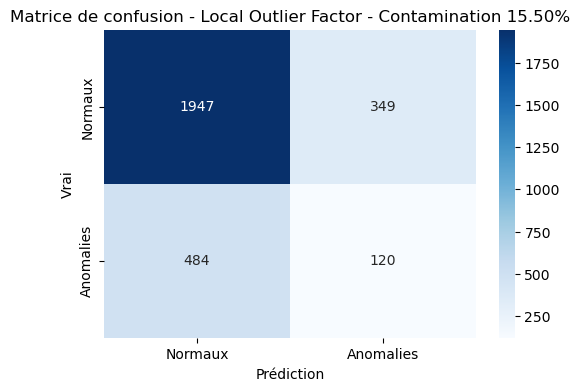

Rapport de classification pour Local Outlier Factor - Contamination 20.33%:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2296
           1       0.24      0.24      0.24       604

    accuracy                           0.68      2900
   macro avg       0.52      0.52      0.52      2900
weighted avg       0.68      0.68      0.68      2900



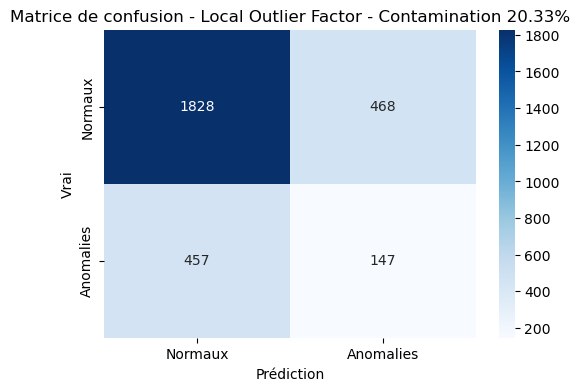

Rapport de classification pour Local Outlier Factor - Contamination 25.17%:

              precision    recall  f1-score   support

           0       0.79      0.74      0.77      2296
           1       0.21      0.27      0.24       604

    accuracy                           0.64      2900
   macro avg       0.50      0.51      0.50      2900
weighted avg       0.67      0.64      0.66      2900



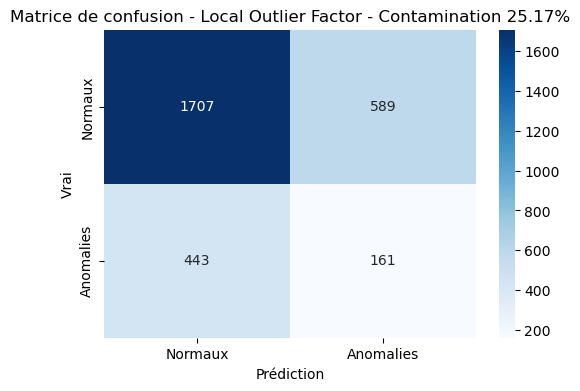

Rapport de classification pour Local Outlier Factor - Contamination 30.00%:

              precision    recall  f1-score   support

           0       0.79      0.69      0.74      2296
           1       0.20      0.30      0.24       604

    accuracy                           0.61      2900
   macro avg       0.50      0.49      0.49      2900
weighted avg       0.67      0.61      0.63      2900



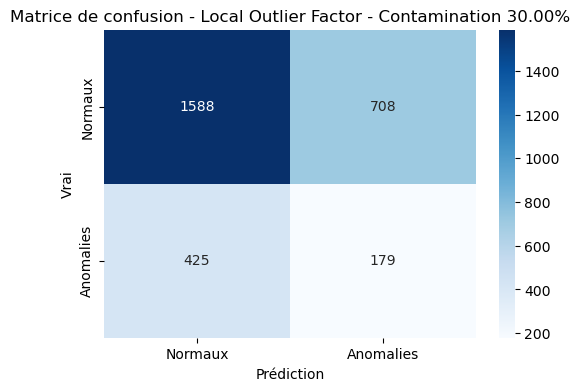

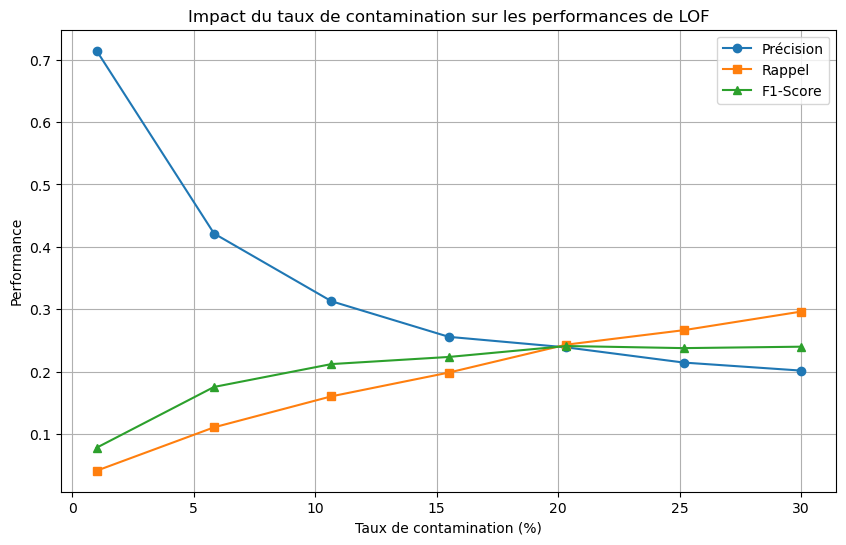

In [62]:
from sklearn.neighbors import LocalOutlierFactor

# Liste des taux de contamination à tester (de 1% à 30%)
contamination_rates = np.linspace(0.01, 0.3, 7)

# Stockage des métriques pour chaque taux de contamination
results = {
    "Contamination": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Boucle sur les taux de contamination
for contamination_rate in contamination_rates:
    # Modèle LOF avec le taux de contamination actuel
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination_rate, novelty=True)
    lof.fit(X_train)  # Entraîner le modèle sur l'ensemble d'entraînement
    
    # Prédictions sur l'ensemble de test
    y_pred_test = (lof.predict(X_test) == -1).astype(int)
    
    # Évaluation des performances
    metrics = evaluate_model(y_test, y_pred_test, f"Local Outlier Factor - Contamination {contamination_rate:.2%}")
    
    # Stocker les résultats
    results["Contamination"].append(contamination_rate * 100)  # Convertir en pourcentage
    results["Precision"].append(metrics["Precision"])
    results["Recall"].append(metrics["Recall"])
    results["F1-Score"].append(metrics["F1-Score"])

# Conversion des résultats en DataFrame pour faciliter l'analyse
results_df = pd.DataFrame(results)

# Tracé des courbes pour chaque métrique
plt.figure(figsize=(10, 6))
plt.plot(results_df["Contamination"], results_df["Precision"], label="Précision", marker='o')
plt.plot(results_df["Contamination"], results_df["Recall"], label="Rappel", marker='s')
plt.plot(results_df["Contamination"], results_df["F1-Score"], label="F1-Score", marker='^')
plt.title("Impact du taux de contamination sur les performances de LOF")
plt.xlabel("Taux de contamination (%)")
plt.ylabel("Performance")
plt.legend()
plt.grid()
plt.show()
